In [4]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torchtext import data
from sklearn.model_selection import train_test_split
from torchsummary import summary
import matplotlib.pyplot as plt
import time 

In [5]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Machine Intelligence 3rd Year Intro to MI Data/Assignment5/data.tsv"

Mounted at /content/drive


# 3. Preparing the data

## 3.1 Create train / validation / test splits

In [6]:
# split the data into train, validation, test using train_test_split;
# combine into dataframe and save as .tsv file 
def split_data(path,seed):
  df = pd.read_csv(path,sep='\t')
  train_ratio = 0.64
  validation_ratio = 0.16
  test_ratio = 0.20
  x_train, x_test, y_train, y_test = train_test_split(df['text'].values, df['label'].values, test_size=1 - train_ratio,stratify=df['label'].values)
  x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio),stratify=y_test) 

  combine_into_tsv(x_train,y_train,'train.tsv')
  combine_into_tsv(x_val,y_val,"validation.tsv")
  combine_into_tsv(x_test,y_test,"test.tsv")

  count_element = 0
  overfit_x,overfit_y = [],[]
  for idx in range(len(x_train)):
    if (count_element == 25):
      break
    if (y_train[idx] == 0):
      overfit_x.append(x_train[idx])
      overfit_y.append(y_train[idx])
      count_element += 1
  
  for idx in range(len(x_train)):
    if (count_element == 50):
      break
    if (y_train[idx] == 1):
      overfit_x.append(x_train[idx])
      overfit_y.append(y_train[idx])
      count_element += 1

  overfit_x = np.array(overfit_x)
  overfit_y = np.array(overfit_y)

  
  combine_into_tsv(overfit_x,overfit_y,"overfit.tsv")

  print('train.tsv:') 
  print('\tObjective:%d; Subjective:%d\n' % (np.unique(y_train, return_counts=True)[1][0], np.unique(y_train, return_counts=True)[1][1]))
  print('validation.tsv:') 
  print('\tObjective:%d; Subjective:%d\n' % (np.unique(y_val, return_counts=True)[1][0], np.unique(y_val, return_counts=True)[1][1]))
  print('test.tsv:') 
  print('\tObjective:%d; Subjective:%d\n' % (np.unique(y_test, return_counts=True)[1][0], np.unique(y_test, return_counts=True)[1][1]))
  print('overfit.tsv:') 
  print('\tObjective:%d; Subjective:%d' % (np.unique(overfit_y, return_counts=True)[1][0], np.unique(overfit_y, return_counts=True)[1][1]))

def combine_into_tsv(x,y,filename):
    df = pd.DataFrame({'text':x,'label':y},columns=['text', 'label']).set_index('text')
    df.to_csv(filename, sep = '\t')

split_data(path,0)

train.tsv:
	Objective:3200; Subjective:3200

validation.tsv:
	Objective:800; Subjective:800

test.tsv:
	Objective:1000; Subjective:1000

overfit.tsv:
	Objective:25; Subjective:25


## 3.2 Process the input data

In [7]:
# note: the 4 files produced in 3.1 have all been manually moved to a folder called data,
# as per the instructions in main.py
def preprocess_data(batch_size=64):
  TEXT = data.Field(sequential=True,lower=True, tokenize='spacy', include_lengths=True)
  LABELS = data.Field(sequential=False, use_vocab=False)

  train_data, val_data, test_data = data.TabularDataset.splits(
        path='data/', train='train.tsv',
        validation='validation.tsv', test='test.tsv', format='tsv',
        skip_header=True, fields=[('text', TEXT), ('label', LABELS)])

  train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (train_data, val_data, test_data), batch_sizes=(batch_size,batch_size,batch_size),
        sort_key=lambda x: len(x.text), device=None, sort_within_batch=True, repeat=False)
  
  overfit_data, _, _ = data.TabularDataset.splits(
            path='data/', train='overfit.tsv',
            validation='validation.tsv', test='test.tsv', format='tsv',
            skip_header=True, fields=[('text', TEXT), ('label', LABELS)])

  overfit_iter, _, _ = data.BucketIterator.splits(
          (overfit_data, val_data, test_data), batch_size = batch_size,
            sort_key=lambda x: len(x.text), device=None, sort_within_batch=True, repeat=False)
  
  TEXT.build_vocab(train_data, val_data, test_data)
  return train_iter,val_iter,test_iter,overfit_iter,TEXT


# 4. Baseline Model and Training

## 4.1 Loadiong GloVe Vector and Using Embedding Layer

In [4]:
# see 4.3 

## 4.2 Baseline Model

In [228]:
class Baseline(nn.Module):
  def __init__(self, embedding_dim, vocab):
    super(Baseline, self).__init__()
    self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
    self.fc = nn.Linear(embedding_dim, 1)

  def forward(self, x, lengths=None):
    #x has shape [sentence length, batch size]
    embedded = self.embedding(x)

    average = embedded.mean(0) # [sentence length, batch size, embedding_dim]
    output = self.fc(average).squeeze(1)
    output = torch.sigmoid(output)

    return output

def load_baseline_model(lr,vocab,embedding_dim):
  model = Baseline(embedding_dim=embedding_dim,vocab=vocab)
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)
  loss_fcn = nn.BCEWithLogitsLoss()
  return model,optimizer,loss_fcn

## 4.3 Training the Baseline Model

In [8]:
lr = 0.001 #@param {type:"number"}
batch_size = 64 #@param {type:"integer"} 

epochs = 25 #@param {type:"integer"}
seed = 0 #@param {type:"integer"}
embedding_dim = 100 #@param {type:"integer"}

In [9]:
train_iter,val_iter,test_iter,overfit_iter,TEXT = preprocess_data(batch_size=batch_size)

In [10]:
TEXT.vocab.load_vectors(torchtext.vocab.GloVe(name='6B', dim=embedding_dim))
vocab = TEXT.vocab
print("Shape of Vocab:",TEXT.vocab.vectors.shape)

.vector_cache/glove.6B.zip: 862MB [06:27, 2.23MB/s]                           
100%|█████████▉| 398859/400000 [00:20<00:00, 19396.33it/s]

Shape of Vocab: torch.Size([21105, 100])


In [11]:
def accuracy(prediction,label):
  total_corr = 0
  prediction = prediction.reshape((len(prediction),))
  label = list(label)
  for i in range (len(prediction)):
    if (prediction[i] == label[i]):
      total_corr += 1
  return (total_corr/len(label))

def plot_acc(epoch, train_acc, val_acc):
    plt.plot(epoch, train_acc, label = 'train_acc')
    plt.plot(epoch, val_acc, label = 'val_acc')
    plt.title('Epochs vs Training/Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Training/Validation Accuracy')
    plt.legend()
    plt.show()

def plot_loss(epoch, train_loss, val_loss):
    plt.plot(epoch, train_loss, label = 'train_loss')
    plt.plot(epoch, val_loss, label = 'val_loss')
    plt.title('Epochs vs Training/Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Training/Validation Loss')
    plt.legend()
    plt.show()

In [216]:
def train_baseline(lr,batch_size,epochs,seed,data_type):
  torch.manual_seed(seed)
  model,optimizer,loss_fcn = load_baseline_model(lr,vocab,embedding_dim)
  if (data_type == "overfit"):
    train_loader = overfit_iter
  elif (data_type == "train"):
    train_loader = train_iter


  train_loss = []
  train_acc = []
  val_loss = []        
  val_acc = []
  tic = time.time() 

  model.train() 
  for epoch in range(epochs):
    mini_train_loss, mini_train_acc = [],[]
    mini_val_loss,mini_val_acc = [],[]
    # training 
    for batch in train_loader:
      batch_input,batch_input_length = batch.text
      labels = batch.label
      optimizer.zero_grad()

      predict = model(batch_input)
      y_pred = np.where(predict > 0.5,1,0)

      loss = loss_fcn(input = predict.squeeze(),target=labels.float())
      
      loss.backward()
      optimizer.step()

      mini_train_loss.append(loss.item())
      mini_train_acc.append(accuracy(y_pred,labels))
    
    # validation 
    for batch in val_iter:
      batch_input,batch_input_length = batch.text
      labels = batch.label
      predict = model(batch_input)
      y_pred = np.where(predict > 0.5,1,0)
      loss = loss_fcn(input = predict.squeeze(),target=labels.float())

      mini_val_loss.append(loss.item())
      mini_val_acc.append(accuracy(y_pred,labels))

    batch_train_loss = np.average(mini_train_loss)
    batch_train_acc = np.average(mini_train_acc)
    batch_val_loss = np.average(mini_val_loss)
    batch_val_acc = np.average(mini_val_acc)

    print(f"epoch:{epoch}")
    print(f"training accuracy:{batch_train_acc}")
    print(f"validation accuracy:{batch_val_acc}")
    print(f"training loss:{batch_train_loss}")
    print(f"validation_loss:{batch_val_loss}")
    print(f"time:{time.time()-tic}\n")

    train_acc.append(batch_train_acc)
    train_loss.append(batch_train_loss)
    val_loss.append(batch_val_loss)
    val_acc.append(batch_val_acc)

  epoch_nums = list(range(epochs)) 
  plot_loss(epoch_nums,train_loss,val_loss)
  plot_acc(epoch_nums,train_acc,val_acc)

  if (data_type=="train"):
    test(model,loss_fcn)

  return model

## 4.4 Overfitting to debug

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch:0
training accuracy:0.5
validation accuracy:0.439375
training loss:0.7302344441413879
validation_loss:0.7248354601860046
time:0.09765410423278809

epoch:1
training accuracy:0.42
validation accuracy:0.500625
training loss:0.7257979512214661
validation_loss:0.7176634407043457
time:0.16784071922302246

epoch:2
training accuracy:0.52
validation accuracy:0.5
training loss:0.7216015458106995
validation_loss:0.7113316512107849
time:0.24153828620910645

epoch:3
training accuracy:0.5
validation accuracy:0.5
training loss:0.7176949977874756
validation_loss:0.7059386324882507
time:0.3110947608947754

epoch:4
training accuracy:0.5
validation accuracy:0.5
training loss:0.7141156196594238
validation_loss:0.7015045738220215
time:0.3817107677459717

epoch:5
training accuracy:0.5
validation accuracy:0.5
training loss:0.7108844518661499
validation_loss:0.6979788970947266
time:0.45001983642578125

epoch:6
training accuracy:0.5
validation accuracy:0.5
training loss:0.7080057263374329
validation_loss

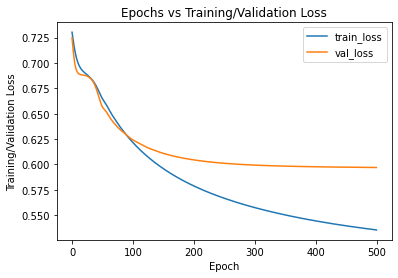

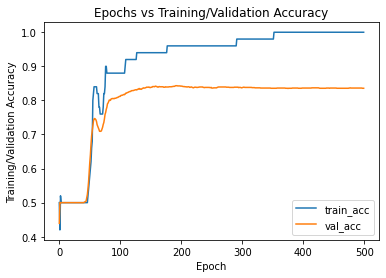

In [217]:
model = train_baseline(lr=0.01,batch_size=batch_size,epochs=500,seed=seed,data_type="overfit")

## 4.5 Full Training Data

In [218]:
def test(model,loss_fcn):
  test_loss = []
  test_acc = []
  for batch in test_iter:
      batch_input, batch_input_length = batch.text
      labels = batch.label
      predict = model(batch_input) 
      y_pred = np.where(predict > 0.5,1,0)
      loss = loss_fcn(input = predict.squeeze(),target=labels.float())

      test_loss.append(loss.item())
      test_acc.append(accuracy(y_pred,labels))
      
  
  print('\nFinal test acc: %f' % (sum(test_acc)/len(test_acc)))
  print('Final test loss: %f' % (sum(test_loss)/len(test_loss)))


epoch:0
training accuracy:0.50015625
validation accuracy:0.5
training loss:0.7083784121274949
validation_loss:0.6945066952705383
time:0.39893341064453125

epoch:1
training accuracy:0.5
validation accuracy:0.5
training loss:0.6895323795080185
validation_loss:0.6861204433441163
time:0.7800166606903076

epoch:2
training accuracy:0.5
validation accuracy:0.5
training loss:0.6823117125034333
validation_loss:0.6792216300964355
time:1.165271282196045

epoch:3
training accuracy:0.50421875
validation accuracy:0.51
training loss:0.6745627868175507
validation_loss:0.6709781908988952
time:1.5428123474121094

epoch:4
training accuracy:0.5384375
validation accuracy:0.56125
training loss:0.6656813621520996
validation_loss:0.6624291729927063
time:1.9266095161437988

epoch:5
training accuracy:0.60296875
validation accuracy:0.643125
training loss:0.6570699697732926
validation_loss:0.6546388292312622
time:2.309209108352661

epoch:6
training accuracy:0.67640625
validation accuracy:0.7175
training loss:0.64

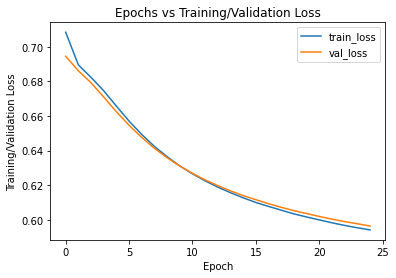

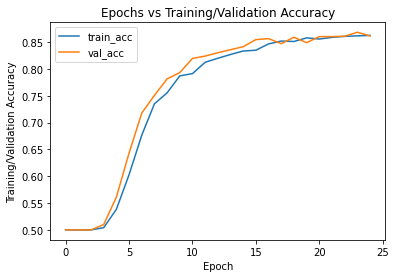


Final test acc: 0.855957
Final test loss: 0.600633


In [229]:
model_baseline = train_baseline(lr,batch_size,epochs,seed,"train")

In [230]:
torch.save(model_baseline,'model_baseline.pt')

# 5. Convolutional Neural Netowrk (CNN)

In [191]:
class CNN(nn.Module):
  def __init__(self, embedding_dim, vocab, n_filters, filter_sizes):
    super(CNN, self).__init__()
    self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (filter_sizes[0], embedding_dim))
    self.conv2 = nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (filter_sizes[1], embedding_dim))
    self.fc = nn.Linear(embedding_dim,1)
    
  def forward(self, x, lengths = None, batch_size=None):
    embedded = self.embedding(x)
    embedded = torch.transpose(embedded,0,1).unsqueeze(1) 
    x1 = F.relu(self.conv1(embedded)) 
    x2 = F.relu(self.conv2(embedded)) 
    x1, _ = torch.max(x1, 2) 
    x2, _ = torch.max(x2, 2) 
    x1 = x1.squeeze(2) 
    x2 = x2.squeeze(2) 
    x = torch.stack((x1, x2),2) 
    if (x.shape[0] != batch_size):
      x = torch.reshape(x,(x.shape[0],100)) 
    else:
      x = torch.reshape(x,(batch_size,100)) 
    out = F.sigmoid(self.fc(x).squeeze(1)) 
    return out

def load_CNN_model(lr,vocab,embedding_dim):
  model = CNN(embedding_dim=embedding_dim,vocab=vocab,n_filters=50,filter_sizes=[2,4])
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)
  loss_fcn = nn.BCEWithLogitsLoss()
  return model,optimizer,loss_fcn

In [192]:
def train_CNN(lr,batch_size,epochs,seed,data_type):
  torch.manual_seed(seed)
  model,optimizer,loss_fcn = load_CNN_model(lr,vocab,embedding_dim)
  if (data_type == "overfit"):
    train_loader = overfit_iter
  elif (data_type == "train"):
    train_loader = train_iter
 
 
  train_loss = []
  train_acc = []
  val_loss = []        
  val_acc = []
  tic = time.time() 

  model.train() 
  for epoch in range(epochs):
    mini_train_loss,mini_train_acc = [],[]
    mini_val_loss,mini_val_acc = [],[]
    # training 
    for batch in train_loader:
      batch_input,batch_input_length = batch.text
      labels = batch.label
      optimizer.zero_grad()
      if (data_type == "overfit"):
        predict = model(batch_input,batch_size=50)
      else:
        predict = model(batch_input,batch_size=batch_size)
      y_pred = np.where(predict > 0.5,1,0)

      loss = loss_fcn(input = predict.squeeze(),target=labels.float())
      
      loss.backward()
      optimizer.step()

      mini_train_loss.append(loss.item())
      mini_train_acc.append(accuracy(y_pred,labels))
    
    # validation 
    for batch in val_iter:
      batch_input,batch_input_length = batch.text
      labels = batch.label
      predict = model(batch_input,batch_size=batch_size)
      y_pred = np.where(predict > 0.5,1,0)
      loss = loss_fcn(input = predict.squeeze(),target=labels.float())

      mini_val_loss.append(loss.item())
      mini_val_acc.append(accuracy(y_pred,labels))

    batch_train_loss = np.average(mini_train_loss)
    batch_train_acc = np.average(mini_train_acc)
    batch_val_loss = np.average(mini_val_loss)
    batch_val_acc = np.average(mini_val_acc)

    print(f"epoch:{epoch}")
    print(f"training accuracy:{batch_train_acc}")
    print(f"validation accuracy:{batch_val_acc}")
    print(f"training loss:{batch_train_loss}")
    print(f"validation_loss:{batch_val_loss}")
    print(f"time:{time.time()-tic}\n")

    train_acc.append(batch_train_acc)
    train_loss.append(batch_train_loss)
    val_loss.append(batch_val_loss)
    val_acc.append(batch_val_acc)

  epoch_nums = list(range(epochs)) 
  plot_loss(epoch_nums,train_loss,val_loss)
  plot_acc(epoch_nums,train_acc,val_acc)

  if (data_type=="train"):
    test_CNN(model,loss_fcn,batch_size)

  return model

## 5.1 Overfit, Training and Test

In [193]:
lr = 0.001 #@param {type:"number"}
batch_size = 64 #@param {type:"integer"} 

epochs = 25 #@param {type:"integer"}
seed = 0 #@param {type:"integer"}
embedding_dim = 100 #@param {type:"integer"}

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch:0
training accuracy:0.46
validation accuracy:0.5
training loss:0.7225363254547119
validation_loss:0.7127834796905518
time:0.31978750228881836

epoch:1
training accuracy:0.5
validation accuracy:0.5
training loss:0.7091473937034607
validation_loss:0.7061098122596741
time:0.5981619358062744

epoch:2
training accuracy:0.5
validation accuracy:0.5
training loss:0.6983899474143982
validation_loss:0.701065878868103
time:0.8670921325683594

epoch:3
training accuracy:0.5
validation accuracy:0.5
training loss:0.6902170777320862
validation_loss:0.6974084424972534
time:1.1393756866455078

epoch:4
training accuracy:0.5
validation accuracy:0.5
training loss:0.684060275554657
validation_loss:0.6947768306732178
time:1.4297642707824707

epoch:5
training accuracy:0.5
validation accuracy:0.5
training loss:0.6793231964111328
validation_loss:0.6928388285636902
time:1.7073194980621338

epoch:6
training accuracy:0.5
validation accuracy:0.5
training loss:0.6754389405250549
validation_loss:0.6913495540618

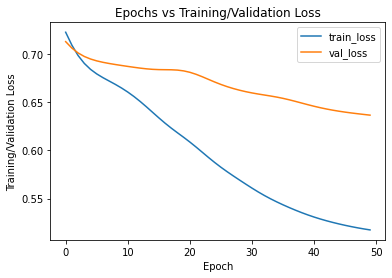

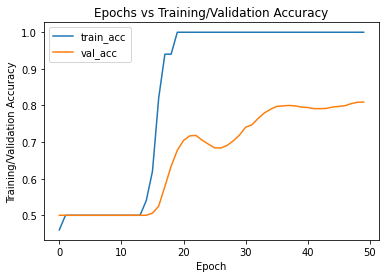

In [174]:
model = train_CNN(lr=0.001,batch_size=batch_size,epochs=50,seed=seed,data_type="overfit")

In [194]:
def test_CNN(model,loss_fcn,batch_size):
  test_loss = []
  test_acc = []
  for batch in test_iter:
    batch_input, batch_input_length = batch.text
    labels = batch.label
    
    predict = model(batch_input,batch_size=batch_size) 
    y_pred = np.where(predict > 0.5,1,0)
    loss = loss_fcn(input = predict.squeeze(),target=labels.float())

    test_loss.append(loss.item())
    test_acc.append(accuracy(y_pred,labels))
      
  
  print('\nFinal test acc: %f' % (sum(test_acc)/len(test_acc)))
  print('Final test loss: %f' % (sum(test_loss)/len(test_loss)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch:0
training accuracy:0.69921875
validation accuracy:0.8575
training loss:0.6396079123020172
validation_loss:0.5869666814804078
time:2.4245526790618896

epoch:1
training accuracy:0.8840625
validation accuracy:0.88125
training loss:0.5674871623516082
validation_loss:0.5717639780044556
time:4.778737783432007

epoch:2
training accuracy:0.9046875
validation accuracy:0.884375
training loss:0.5551190492510796
validation_loss:0.5612919330596924
time:7.1239914894104

epoch:3
training accuracy:0.9184375
validation accuracy:0.89
training loss:0.5469404068589211
validation_loss:0.5576477837562561
time:9.47446346282959

epoch:4
training accuracy:0.93484375
validation accuracy:0.900625
training loss:0.5402770617604256
validation_loss:0.5554387068748474
time:11.86802077293396

epoch:5
training accuracy:0.94390625
validation accuracy:0.90375
training loss:0.5359307059645653
validation_loss:0.5533421301841736
time:14.273094654083252

epoch:6
training accuracy:0.95109375
validation accuracy:0.91
tr

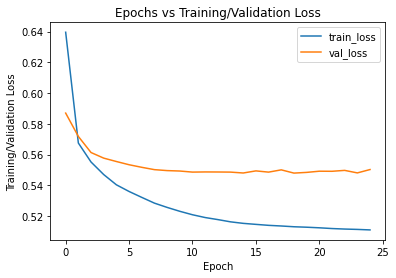

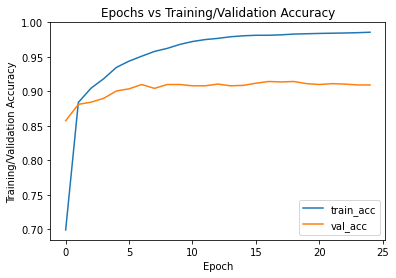


Final test acc: 0.916992
Final test loss: 0.550166


In [195]:
model_cnn = train_CNN(lr=lr,batch_size=batch_size,epochs=epochs,seed=seed,data_type="train")

In [196]:
torch.save(model_cnn,'model_cnn.pt')

# 6. Recurrent Neural Network (RNN)

In [254]:
class RNN(nn.Module):
  def __init__(self,embedding_dim,vocab,hidden_dim):
    super(RNN,self).__init__()
    self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
    self.gru = nn.GRU(input_size = embedding_dim, hidden_size = hidden_dim)
    self.fc = nn.Linear(embedding_dim, 1)

  def forward(self,x,lengths = None):
    embedded = self.embedding(x)
    embedded = torch.transpose(embedded,0,1)
    x = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True) 
    x_unpacked, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
    x, _ = self.gru(x_unpacked) 
    x = torch.transpose(x,0,1) 
    avg = x.mean(0)
    out = self.fc(avg).squeeze(1) 
    out = F.sigmoid(output)
    return out

def load_RNN_model(lr,vocab,embedding_dim):
  model = RNN(embedding_dim=embedding_dim,vocab=vocab,hidden_dim=100)
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)
  loss_fcn = nn.BCEWithLogitsLoss()
  return model,optimizer,loss_fcn

In [255]:
def train_RNN(lr,batch_size,epochs,seed,data_type):
  torch.manual_seed(seed)
  model,optimizer,loss_fcn = load_RNN_model(lr,vocab,embedding_dim)
  if (data_type == "overfit"):
    train_loader = overfit_iter
  elif (data_type == "train"):
    train_loader = train_iter
 
  train_loss = []
  train_acc = []
  val_loss = []        
  val_acc = []
  tic = time.time() 

  model.train() 
  for epoch in range(epochs):
    mini_train_loss,mini_train_acc = [],[]
    mini_val_loss,mini_val_acc = [],[]
    # training 
    for batch in train_loader:
      batch_input,batch_input_length = batch.text
      
      labels = batch.label
      optimizer.zero_grad()
  
      predict = model(batch_input,lengths=batch_input_length)
      y_pred = np.where(predict > 0.5,1,0)

      loss = loss_fcn(input = predict.squeeze(),target=labels.float())
      
      loss.backward()
      optimizer.step()

      mini_train_loss.append(loss.item())
      mini_train_acc.append(accuracy(y_pred,labels))
    
    # validation 
    for batch in val_iter:
      batch_input,batch_input_length = batch.text
     
      labels = batch.label
      predict = model(batch_input,lengths = batch_input_length)
      y_pred = np.where(predict > 0.5,1,0)
      loss = loss_fcn(input = predict.squeeze(),target=labels.float())

      mini_val_loss.append(loss.item())
      mini_val_acc.append(accuracy(y_pred,labels))

    batch_train_loss = np.average(mini_train_loss)
    batch_train_acc = np.average(mini_train_acc)
    batch_val_loss = np.average(mini_val_loss)
    batch_val_acc = np.average(mini_val_acc)

    print(f"epoch:{epoch}")
    print(f"training accuracy:{batch_train_acc}")
    print(f"validation accuracy:{batch_val_acc}")
    print(f"training loss:{batch_train_loss}")
    print(f"validation_loss:{batch_val_loss}")
    print(f"time:{time.time()-tic}\n")

    train_acc.append(batch_train_acc)
    train_loss.append(batch_train_loss)
    val_loss.append(batch_val_loss)
    val_acc.append(batch_val_acc)

  epoch_nums = list(range(epochs)) 
  plot_loss(epoch_nums,train_loss,val_loss)
  plot_acc(epoch_nums,train_acc,val_acc)

  if (data_type=="train"):
    test_RNN(model,loss_fcn)

  return model

## 6.1 Overfit, Training and Test

In [259]:
lr = 0.001 #@param {type:"number"}
batch_size = 64 #@param {type:"integer"} 

epochs = 25 #@param {type:"integer"}
seed = 0 #@param {type:"integer"}
embedding_dim = 100 #@param {type:"integer"}

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch:0
training accuracy:0.5
validation accuracy:0.5
training loss:0.7227728962898254
validation_loss:0.6956366539001465
time:0.5443181991577148

epoch:1
training accuracy:0.5
validation accuracy:0.5
training loss:0.7029054164886475
validation_loss:0.6926926565170288
time:1.052145004272461

epoch:2
training accuracy:0.5
validation accuracy:0.5
training loss:0.6937838196754456
validation_loss:0.6926974439620972
time:1.5640614032745361

epoch:3
training accuracy:0.5
validation accuracy:0.5
training loss:0.6914520263671875
validation_loss:0.6927579402923584
time:2.0672669410705566

epoch:4
training accuracy:0.5
validation accuracy:0.5
training loss:0.6914974451065063
validation_loss:0.6927800273895264
time:2.563232660293579

epoch:5
training accuracy:0.5
validation accuracy:0.5
training loss:0.6915658712387085
validation_loss:0.6927633881568909
time:3.075810670852661

epoch:6
training accuracy:0.5
validation accuracy:0.5
training loss:0.6914966702461243
validation_loss:0.692715756893158


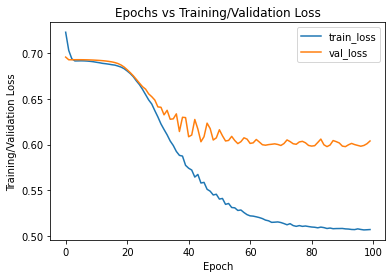

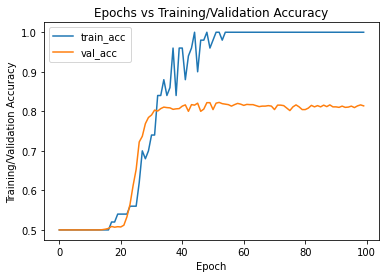

In [182]:
model = train_RNN(lr=0.01,batch_size=batch_size,epochs=100,seed=seed,data_type="overfit")

In [15]:
def test_RNN(model,loss_fcn):
  test_loss = []
  test_acc = []
  for batch in test_iter:
    batch_input, batch_input_length = batch.text
    labels = batch.label
    
    predict = model(batch_input,lengths = batch_input_length) 
    y_pred = np.where(predict > 0.5,1,0)
    loss = loss_fcn(input = predict.squeeze(),target=labels.float())

    test_loss.append(loss.item())
    test_acc.append(accuracy(y_pred,labels))
      
  
  print('\nFinal test acc: %f' % (sum(test_acc)/len(test_acc)))
  print('Final test loss: %f' % (sum(test_loss)/len(test_loss)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch:0
training accuracy:0.5
validation accuracy:0.5
training loss:0.6941841679811478
validation_loss:0.6845438599586486
time:4.342031002044678

epoch:1
training accuracy:0.709375
validation accuracy:0.84
training loss:0.6371827852725983
validation_loss:0.600220046043396
time:8.808154821395874

epoch:2
training accuracy:0.8571875
validation accuracy:0.86125
training loss:0.5869541823863983
validation_loss:0.58130925655365
time:13.464826583862305

epoch:3
training accuracy:0.87453125
validation accuracy:0.87875
training loss:0.5747937649488449
validation_loss:0.5766582942008972
time:17.833096265792847

epoch:4
training accuracy:0.87921875
validation accuracy:0.879375
training loss:0.5703824955224991
validation_loss:0.5706343388557434
time:22.255040168762207

epoch:5
training accuracy:0.88734375
validation accuracy:0.88125
training loss:0.5651458197832108
validation_loss:0.5677079272270202
time:26.791930437088013

epoch:6
training accuracy:0.89046875
validation accuracy:0.889375
trainin

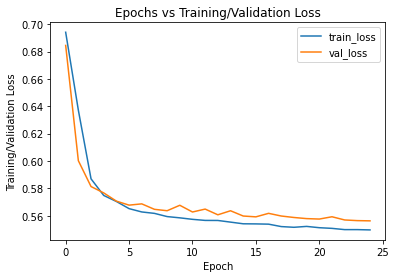

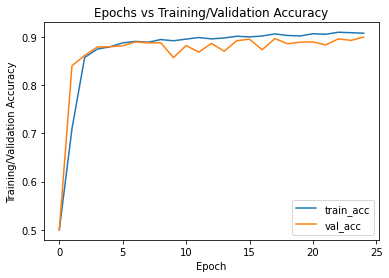


Final test acc: 0.903320
Final test loss: 0.558055


In [202]:
model_rnn = train_RNN(lr=lr,batch_size=batch_size,epochs=epochs,seed=seed,data_type="train")

In [203]:
torch.save(model_rnn,"model_rnn.pt")

### RNN without 'pack_padded_sequence'

In [12]:
class RNN_2(nn.Module):
  def __init__(self,embedding_dim,vocab,hidden_dim):
    super(RNN_2,self).__init__()
    self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
    self.gru = nn.GRU(input_size = embedding_dim, hidden_size = hidden_dim)
    self.fc = nn.Linear(embedding_dim, 1)

  def forward(self,x,lengths = None):
    embedded = self.embedding(x)
    embedded = torch.transpose(embedded,0,1)
    x, _ = self.gru(embedded) 
    x = torch.transpose(x,0,1) 
    avg = x.mean(0)
    out = self.fc(avg).squeeze(1) 
    out = F.sigmoid(output)
    return out


def load_RNN2_model(lr,vocab,embedding_dim):
  model = RNN_2(embedding_dim=embedding_dim,vocab=vocab,hidden_dim=100)
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)
  loss_fcn = nn.BCEWithLogitsLoss()
  return model,optimizer,loss_fcn

In [13]:
def train_RNN2(lr,batch_size,epochs,seed,data_type):
  torch.manual_seed(seed)
  model,optimizer,loss_fcn = load_RNN2_model(lr,vocab,embedding_dim)
  if (data_type == "overfit"):
    train_loader = overfit_iter
  elif (data_type == "train"):
    train_loader = train_iter
 
  train_loss = []
  train_acc = []
  val_loss = []        
  val_acc = []
  tic = time.time() 

  model.train() 
  for epoch in range(epochs):
    mini_train_loss,mini_train_acc = [],[]
    mini_val_loss,mini_val_acc = [],[]
    # training 
    for batch in train_loader:
      batch_input,batch_input_length = batch.text
      
      labels = batch.label
      optimizer.zero_grad()
  
      predict = model(batch_input,lengths=batch_input_length)
      y_pred = np.where(predict > 0.5,1,0)

      loss = loss_fcn(input = predict.squeeze(),target=labels.float())
      
      loss.backward()
      optimizer.step()

      mini_train_loss.append(loss.item())
      mini_train_acc.append(accuracy(y_pred,labels))
    
    # validation 
    for batch in val_iter:
      batch_input,batch_input_length = batch.text
     
      labels = batch.label
      predict = model(batch_input,lengths = batch_input_length)
      y_pred = np.where(predict > 0.5,1,0)
      loss = loss_fcn(input = predict.squeeze(),target=labels.float())

      mini_val_loss.append(loss.item())
      mini_val_acc.append(accuracy(y_pred,labels))

    batch_train_loss = np.average(mini_train_loss)
    batch_train_acc = np.average(mini_train_acc)
    batch_val_loss = np.average(mini_val_loss)
    batch_val_acc = np.average(mini_val_acc)

    print(f"epoch:{epoch}")
    print(f"training accuracy:{batch_train_acc}")
    print(f"validation accuracy:{batch_val_acc}")
    print(f"training loss:{batch_train_loss}")
    print(f"validation_loss:{batch_val_loss}")
    print(f"time:{time.time()-tic}\n")

    train_acc.append(batch_train_acc)
    train_loss.append(batch_train_loss)
    val_loss.append(batch_val_loss)
    val_acc.append(batch_val_acc)

  epoch_nums = list(range(epochs)) 
  plot_loss(epoch_nums,train_loss,val_loss)
  plot_acc(epoch_nums,train_acc,val_acc)

  if (data_type=="train"):
    test_RNN(model,loss_fcn)

  return model

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch:0
training accuracy:0.51734375
validation accuracy:0.699375
training loss:0.6833350706100464
validation_loss:0.6441738486289978
time:4.508059501647949

epoch:1
training accuracy:0.81484375
validation accuracy:0.869375
training loss:0.6117010569572449
validation_loss:0.5859756064414978
time:9.01682162284851

epoch:2
training accuracy:0.86234375
validation accuracy:0.885625
training loss:0.5829135596752166
validation_loss:0.5725650119781495
time:13.570110559463501

epoch:3
training accuracy:0.86828125
validation accuracy:0.898125
training loss:0.5752575016021728
validation_loss:0.5680798506736755
time:18.122976303100586

epoch:4
training accuracy:0.87515625
validation accuracy:0.90125
training loss:0.5702112552523613
validation_loss:0.5629354906082153
time:22.68242335319519

epoch:5
training accuracy:0.87875
validation accuracy:0.8875
training loss:0.5674535718560219
validation_loss:0.5615707731246948
time:27.34230661392212

epoch:6
training accuracy:0.88328125
validation accuracy:

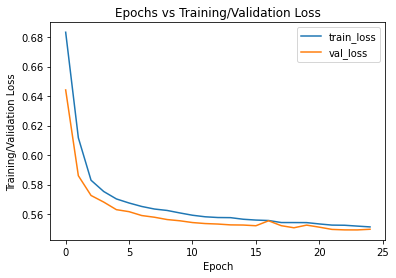

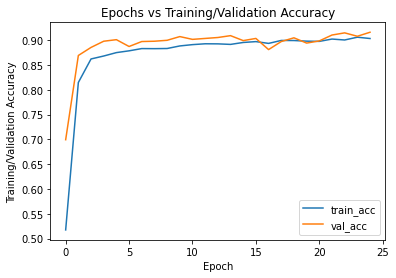


Final test acc: 0.903809
Final test loss: 0.556759


In [16]:
model_rnn_2 = train_RNN2(lr=lr,batch_size=batch_size,epochs=epochs,seed=seed,data_type="train")

### RNN without 'pack_padded_sequence' and using Iterator 

In [17]:
def preprocess_data_2(batch_size=64):
  TEXT = data.Field(sequential=True,lower=True, tokenize='spacy', include_lengths=True)
  LABELS = data.Field(sequential=False, use_vocab=False)

  train_data, val_data, test_data = data.TabularDataset.splits(
        path='data/', train='train.tsv',
        validation='validation.tsv', test='test.tsv', format='tsv',
        skip_header=True, fields=[('text', TEXT), ('label', LABELS)])

  train_iter, val_iter, test_iter = data.Iterator.splits(
        (train_data, val_data, test_data), batch_sizes=(batch_size,batch_size,batch_size),
        sort_key=lambda x: len(x.text), device=None, sort_within_batch=True, repeat=False)
  
  overfit_data, _, _ = data.TabularDataset.splits(
            path='data/', train='overfit.tsv',
            validation='validation.tsv', test='test.tsv', format='tsv',
            skip_header=True, fields=[('text', TEXT), ('label', LABELS)])

  overfit_iter, _, _ = data.Iterator.splits(
          (overfit_data, val_data, test_data), batch_size = batch_size,
            sort_key=lambda x: len(x.text), device=None, sort_within_batch=True, repeat=False)
  
  TEXT.build_vocab(train_data, val_data, test_data)
  return train_iter,val_iter,test_iter,overfit_iter,TEXT
train_iter,val_iter,test_iter,overfit_iter,TEXT = preprocess_data_2()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch:0
training accuracy:0.50015625
validation accuracy:0.5
training loss:0.6953319561481476
validation_loss:0.6881350064277649
time:6.752117872238159

epoch:1
training accuracy:0.615625
validation accuracy:0.85875
training loss:0.6596632838249207
validation_loss:0.5844564962387085
time:13.586561679840088

epoch:2
training accuracy:0.8184375
validation accuracy:0.89375
training loss:0.6115818691253662
validation_loss:0.5664762759208679
time:20.452388763427734

epoch:3
training accuracy:0.85453125
validation accuracy:0.893125
training loss:0.5930567044019699
validation_loss:0.5647171831130982
time:27.289963483810425

epoch:4
training accuracy:0.86296875
validation accuracy:0.89875
training loss:0.5848992598056794
validation_loss:0.5580375647544861
time:33.98133444786072

epoch:5
training accuracy:0.868125
validation accuracy:0.891875
training loss:0.5794049501419067
validation_loss:0.5563622117042542
time:40.91099238395691

epoch:6
training accuracy:0.87125
validation accuracy:0.900625

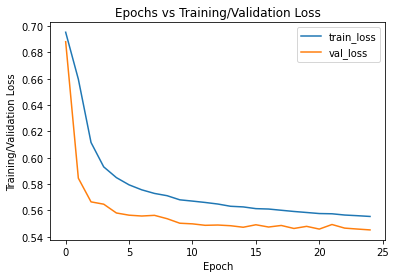

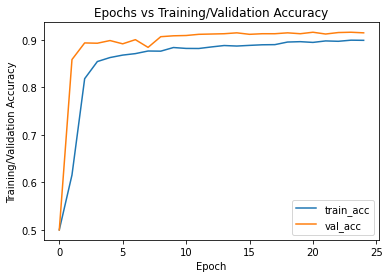


Final test acc: 0.902344
Final test loss: 0.555601


In [18]:
model_rnn_3 = train_RNN2(lr=lr,batch_size=batch_size,epochs=epochs,seed=seed,data_type="train")

# 7. Testing on Your Own Sentence

In [221]:
import spacy
# loading vocab object
TEXT.vocab.load_vectors(torchtext.vocab.GloVe(name='6B', dim=embedding_dim))
vocab = TEXT.vocab

In [234]:
model_baseline = torch.load('model_baseline.pt')
model_cnn = torch.load('model_cnn.pt')
model_rnn = torch.load('model_rnn.pt')

In [223]:
def tokenizer(text):
  spacy_en = spacy.load('en')
  return [tok.text for tok in spacy_en(text)]

def tokenize(sentence):
  tokens = tokenizer(sentence)
  token_ints = [vocab.stoi[tok] for tok in tokens]
  token_tensor = torch.LongTensor(token_ints).view(-1,1)
  lengths = torch.Tensor([len(token_ints)])
  return token_tensor,lengths

In [275]:
def subjective_bot():
  input("Welcome to Subjective Bot! [press enter to continue]")
  sentence = ""
  while (True):
    sentence = input("Enter a sentence:\n")
    if (sentence == "-1"):
      break
    token_tensor,lengths = tokenize(sentence)
    predict_baseline = model_baseline(token_tensor)
    predict_cnn = model_cnn(token_tensor)
    predict_rnn = model_rnn(token_tensor,lengths)

    if (predict_baseline > 0.5):
      category_baseline = "subjective"
    else:
      category_baseline = "objective"
    if (predict_cnn > 0.5):
      category_cnn = "subjective"
    else:
      category_cnn = "objective"
    if (predict_rnn > 0.5):
      category_rnn = "subjective"
    else:
      category_rnn = "objective"
  
    print(f"Model baseline:{category_baseline} ({round(predict_baseline.data.tolist()[0],3)})")
    print(f"Model cnn:{category_cnn} ({round(predict_cnn.data.tolist()[0],3)})")
    print(f"Model rnn:{category_rnn} ({round(predict_rnn.data.tolist()[0],3)})\n")

  print("Done!")


In [280]:
subjective_bot()

Welcome to Subjective Bot! [press enter to continue]
Enter a sentence:
I think the weather is nice outside


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Model baseline:subjective (0.856)
Model cnn:subjective (0.903)
Model rnn:subjective (0.943)

Enter a sentence:
Young failed the course
Model baseline:objective (0.104)
Model cnn:objective (0.234)
Model rnn:objective (0.01)

Enter a sentence:
Programming is an essential engineering course
Model baseline:subjective (0.836)
Model cnn:objective (0.149)
Model rnn:subjective (0.992)

Enter a sentence:
Money equals to happiness
Model baseline:subjective (0.835)
Model cnn:subjective (0.502)
Model rnn:objective (0.232)

Enter a sentence:
-1
Done!
